In [1]:
from load_data import load_help_desk_dataset
import explore_data
import vectorize_data as vec
import train_ngram_model
import numpy as np
import os
import pandas as pd
from train_sequence_model import train_sequence_model
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from tensorflow import keras
from bayes_result import get_bayes_result
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
#ONLY REQUIRED GLOBAL VARIABLE FOR DEMO - SET TO FALSE TO TRAIN MODEL AGAIN
USE_PRELOAD = True

In [14]:
#THESE ARE USER PROVIDED PARAMETERS
FILENAME = ".\\all_tickets.csv"
#column name containing the label values
COLUMN_NAME = 'business_service'
#if certain label values should be ignored, list them here
IGNORE_VALUES = [32,36,4,40,46,51,56,63,66,67,68,70,73]


In [ ]:
#DATA CLEANING - produces two CSV files for train and test - train has 5k records and test has 1.2k

In [15]:
#specify file name to load all the data
all_data = pd.read_csv(FILENAME)

#This section is not fully parameterized and would need updating for a different use case

#Select just the services known to have more than 1000 examples in dataset
my_services=IGNORE_VALUES

#make a mapping for the values so we have a constant set of labels - needed for the MLP script
service_labels ={}
i=0
for service in my_services:
    service_labels[service]=i
    i=i+1
#reduce the full dataset to just these values
all_data = all_data[all_data[COLUMN_NAME].isin(my_services)]

#Create a mapping for these services to a continuous sequence to work with scripts - new values go in column called "Label"
all_data['label']=all_data[COLUMN_NAME]
all_data['label']=all_data['label'].map(service_labels)

#Take a stratified sample of half the dataset to reduce size so it works for our ML testing - laptop could not crunch model for all data
train, test = train_test_split(all_data, test_size=0.5, stratify=all_data['label'])



#Use the stratified 20% sample from before to create our actual test/train sets - save these to separate CSV files
small_train, small_test = train_test_split(test, test_size=0.2, stratify=test['label'])
small_test.to_csv(".\\test.csv",index=False,header=False,columns=['label','title','body',COLUMN_NAME])
small_train.to_csv(".\\train.csv",index=False,header=False,columns=['label','title','body',COLUMN_NAME])

#If we want to use full sample...
#test.to_csv(".\\test.csv",index=False,header=False,columns=['label','title','body','business_service'])
#train.to_csv(".\\train.csv",index=False,header=False,columns=['label','title','body','business_service'])


In [16]:
#We now have the two stratified data files we need - load them into variables needed for training and testing
#load dataset is modified to just be told what directory files are in
data = load_help_desk_dataset('.\\')
#Output the text and labels
(train_texts, train_labels), (val_texts, val_labels) = data

In [19]:
#Train the ngram MLP model - will also save a serialized version - defaults to 20 epochs
if (USE_PRELOAD == False):
    train_ngram_model.train_ngram_model(data)

In [8]:
# load the ngram model that's been trained to use for prediction
model= keras.models.load_model(".\\helpdesk_MLP.h5")

In [ ]:
#NOT CURRENTLY IN USE - TRAINS CNN SEQUENCE MODEL
#This model did not seem to work in this scenario. This is addressed in the documentation report 
#train_sequence_model(data)

In [9]:
#Calculate Bayes using the same data set
#Makes a call to the separate script that uses NLTK library to calculate Bayes
bayes_label, bayes_predicted = get_bayes_result(train_texts, train_labels, val_texts, val_labels)

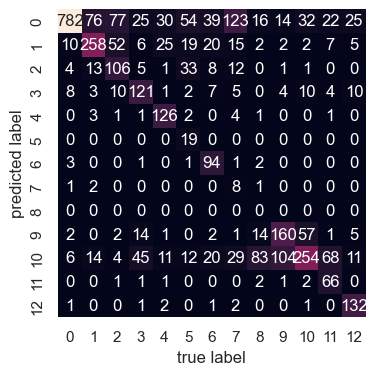

              precision    recall  f1-score   support

           0       0.59      0.96      0.73       817
           1       0.61      0.70      0.65       369
           2       0.58      0.42      0.49       253
           3       0.65      0.55      0.60       220
           4       0.91      0.64      0.75       198
           5       1.00      0.13      0.24       142
           6       0.92      0.49      0.64       191
           7       0.67      0.04      0.08       200
           8       0.00      0.00      0.00       121
           9       0.62      0.56      0.59       286
          10       0.38      0.71      0.50       359
          11       0.89      0.39      0.54       169
          12       0.94      0.70      0.80       188

    accuracy                           0.61      3513
   macro avg       0.67      0.48      0.51      3513
weighted avg       0.65      0.61      0.57      3513



C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
%matplotlib inline
#make a confusion matrix and classification report for the bayes approach
mat = confusion_matrix(bayes_label, bayes_predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(bayes_label),
            yticklabels=np.unique(bayes_label))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(bayes_label, bayes_predicted))

In [11]:
#Need to create TF-IDF vectors as input for the MLP model - top 20k features
x_train, x_val = vec.ngram_vectorize(
        train_texts, train_labels, val_texts)

C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\feature_extraction\text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\thoma\anaconda3\envs\tisfinal\lib\site-

In [12]:
#Create predictions using the model we loaded with the vectors we just created
y_prob = model.predict(x_val[0:]) 
#Convert the probabilities to most likely class/label
y_classes = y_prob.argmax(axis=-1)

110/110 [==============================] - 0s 2ms/step


In [268]:
    #Not currenlty in use
    #Map labels back to original business service values - had to change for the 
    #Get a flipped dictionary of labels to biz services for re-mapping
    #inv_labels = {v: k for k, v in service_labels.items()}
    #map labels back to original business service values
    #val_labels =np.asarray([*map(inv_labels.get,val_labels)])
    #y_classes = np.asarray([*map(inv_labels.get,y_classes)])
    

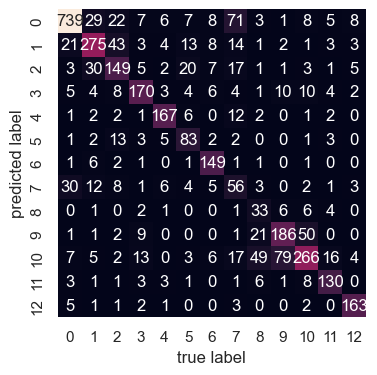

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       817
           1       0.70      0.75      0.72       369
           2       0.61      0.59      0.60       253
           3       0.74      0.77      0.75       220
           4       0.85      0.84      0.85       198
           5       0.72      0.58      0.65       142
           6       0.91      0.78      0.84       191
           7       0.43      0.28      0.34       200
           8       0.61      0.27      0.38       121
           9       0.69      0.65      0.67       286
          10       0.57      0.74      0.64       359
          11       0.82      0.77      0.80       169
          12       0.92      0.87      0.89       188

    accuracy                           0.73      3513
   macro avg       0.72      0.68      0.69      3513
weighted avg       0.73      0.73      0.72      3513



In [13]:
    #Generate confusion matrix and classification report for the MLP results
    %matplotlib inline
    #Generate Reports
   
    mat = confusion_matrix(val_labels, y_classes)
    plt.figure(figsize=(4, 4))
    sns.set()
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(val_labels),
                yticklabels=np.unique(val_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

    # Printing classification report
    
    print(classification_report(val_labels, y_classes))

In [ ]:
#At this point, we can explore the two models' outputs and compare performance 